# Multivariate statistics (decoding / MVPA) on M/EEG

`Code source : Alexandre Gramfort, Richard Höchenberge 
 Modified by Annalisa Pascarella, Vanessa Hadid`

Decoding in MNE largely follows the machine learning API of the [`scikit-learn`](https://scikit-learn.org/stable/) package. We'll learn how to decode M/EEG evoked activity.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

We set the log-level to 'WARNING' so the output is less verbose

In [2]:
mne.set_log_level('WARNING')

## Access the raw data

Now we import the [`sample`](https://mne.tools/stable/documentation/datasets.html#sample-dataset) dataset. It's the same dataset of previous tutorial.

In [3]:
from mne.datasets import sample
data_path = sample.data_path()

raw_fname = os.path.join(data_path, 'MEG/sample/sample_audvis_filt-0-40_raw.fif')
print(raw_fname)
raw = mne.io.read_raw_fif(raw_fname, preload=True)

/home/hyruuk/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif


High-pass filter the data.

In [4]:
raw.filter(l_freq=1, h_freq=None, verbose=True)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    0.3s finished


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.9 MiB, data loaded>

## Define epochs

We look at the `auditory left` and `auditory right` stimuli. Let's extract the events and create the `Epochs` object.

In [5]:
events = mne.find_events(raw, stim_channel='STI 014', verbose=True)

319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


/tmp/ipykernel_27036/1630066419.py:2: RuntimeWarning: event 3 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
/tmp/ipykernel_27036/1630066419.py:2: RuntimeWarning: event 4 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
/tmp/ipykernel_27036/1630066419.py:2: RuntimeWarning: event 5 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
/tmp/ipykernel_27036/1630066419.py:2: RuntimeWarning: event 32 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],


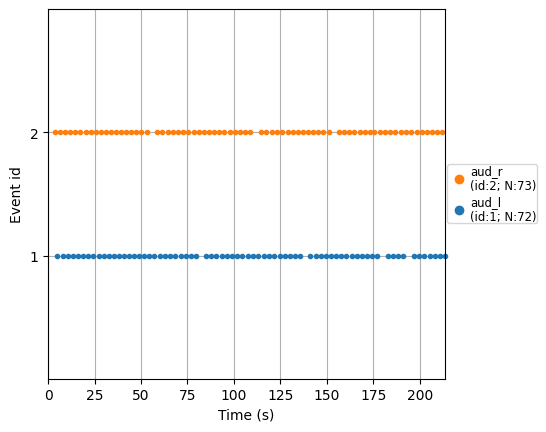

In [6]:
event_id = {'aud_l': 1, 'aud_r': 2}  # event trigger and conditions
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_id)

Define epochs parameters:

In [7]:
tmin = -0.1  # start of each epoch (in seconds)
tmax = 0.4   # end of each epoch
baseline = None  # no baseline correction, data were high-pass filtered

reject = dict(eeg=80e-6, eog=40e-6)
picks = mne.pick_types(raw.info, eeg=True, meg=True,
                       eog=True, stim=False, exclude='bads')

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline,
                    reject=reject, preload=True)  # with preload

print(epochs.get_data(copy=True).shape)

(110, 365, 76)


## Spatio-temporal decoding

Now let's see if we can discriminate experimental conditions from single trials. \
To keep chance level at 50% accuracy, we first equalize the number of epochs in each condition.

In [8]:
epochs.equalize_event_counts(event_id)
print(epochs)

<Epochs | 108 events (all good), -0.1 – 0.4 s (baseline off), ~26.1 MiB, data loaded,
 'aud_l': 54
 'aud_r': 54>


A classifier takes as input an `X` and returns `y` (0 or 1). Here `X` will be the data at each time point on all gradiometers (hence the term multivariate). We want to train our model to discriminate between the  `auditory left` and the `auditory right` trials.

We try to find a discriminative pattern between the two conditions to predict the class.

For classification we will use the scikit-learn package (http://scikit-learn.org/) and MNE functions.

Let's first create the response vector, `y`.

In [9]:
import numpy as np

y = np.empty(len(epochs.events), dtype=int)
idx_auditory_left = epochs.events[:, 2] == event_id['aud_l']
idx_auditory_right = epochs.events[:, 2] == event_id['aud_r']
y[idx_auditory_left] = 0
y[idx_auditory_right] = 1

y.size

108

Now, the input matrix, `X`.

In [10]:
X = epochs.copy().pick_types(meg='grad').get_data()
X.shape  # n_epochs x n_chs x n_tp

(108, 203, 76)

In [11]:
XX = X.reshape(108, -1)
XX.shape

(108, 15428)

Here we estimate the accuracy of a [`Logistic Regression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time):

In [12]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

logreg = LogisticRegression(solver='liblinear')  # liblinear is the algorithm used to fit the model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = make_pipeline(StandardScaler(), logreg)

scores = cross_val_score(clf, XX, y, cv=cv, scoring='roc_auc')

roc_auc_mean = np.mean(scores)
roc_auc_std = np.std(scores)

print(f'CV scores: {scores}')
print(f'Mean ROC AUC = {roc_auc_mean:.3f} (std: {roc_auc_std:.3f})')

CV scores: [0.8677686  0.87603306 0.89256198 0.9        0.89090909]
Mean ROC AUC = 0.885 (std: 0.012)


In scikit-learn [`Pipeline`](https://scikit-learn.org/stable/modules/compose.html#pipeline) can be used to chain multiple estimators into one. \
[`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set. \
[`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) returns the array of scores of the estimator for each run of the cross validation. Here we use the Area Under the Curve (AUC) of the  [`Receiver Operating Characteristic (ROC)`](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py) curves.

### Let's use `mne.decoding` module

In [13]:
from sklearn.pipeline import make_pipeline
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore, LinearModel, get_coef


In [14]:
epochs_decoding = epochs.copy().pick_types(meg='grad')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = make_pipeline(Scaler(epochs_decoding.info),
                    Vectorizer(), 
                    logreg)

X = epochs_decoding.get_data()
y = epochs_decoding.events[:, 2]

scores = cross_val_multiscore(clf, X, y, cv=cv, scoring='roc_auc')

roc_auc_mean = np.mean(scores)
roc_auc_std = np.std(scores)

print(f'CV scores: {scores}')
print(f'Mean ROC AUC = {roc_auc_mean:.3f} (std: {roc_auc_std:.3f})')

CV scores: [0.90082645 0.90082645 0.95867769 0.93636364 0.91818182]
Mean ROC AUC = 0.923 (std: 0.022)


The [`mne.decoding.Scaler`](https://mne.tools/stable/generated/mne.decoding.Scaler.html#mne.decoding.Scaler) scales each channel by estimating μ and σ using data from all time points and epochs. Using this class is different from directly applying [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) that scales each classification feature, e.g. each time point for each channel, with mean and standard deviation computed across epochs. \
scikit-learn transformers and estimators generally expect 2D data (n_samples * n_features), whereas MNE transformers typically output data with a higher dimensionality (e.g. n_samples * n_channels * n_times). A [`Vectorizer`](https://mne.tools/stable/generated/mne.decoding.Vectorizer.html#mne.decoding.Vectorizer) transforms n-dimensional array into 2D array of n_samples by n_features.

<div class="alert alert-success">
    <b>EXERCISES:</b>
     <ul>
      <li>Why do you get different results from above? </li>
      <li>How does the choice of cross-validation affect the results? Hint: Change the random_state</li>
      <li>Try a different cross-validtion object like scikit-learn KFold, StratifiedShuffleSplit</li>
      <li>Try a different score in the cross_val_multiscore function</li>
      <li>Which sensor types give the best classification scores? EEG, MEG gradiometers, MEG magnetometers?</li>
    </ul>
</div>

## Decoding over time

In the previous examples, we have trained a classifier to discriminate between experimentel conditions by using the spatio-temporal patterns of **entire trials**. The classifier was able to predict which activation pattern belonged to which condition. 

However, an interesting neuroscientific is: **Exactly *when* do the brain signals for two conditions differ?**

We can try to answer this question by fitting a classifier **at every single time point.** If the classifier can successfully discriminate between the two conditions, we can conclude that the spatial activation patterns measured by the M/EEG sensors differed **at this time point**. \
This strategy consists in fitting a multivariate predictive model on each time instant and evaluating its performance at the same instant on new epochs. 

The [`mne.decoding.SlidingEstimator`](https://mne.tools/stable/generated/mne.decoding.SlidingEstimator.html#mne.decoding.SlidingEstimator) will take as input a pair of features `X`
and targets `y`, where `X`has more than 2 dimensions. 

Mean CV score across all time points: 0.590


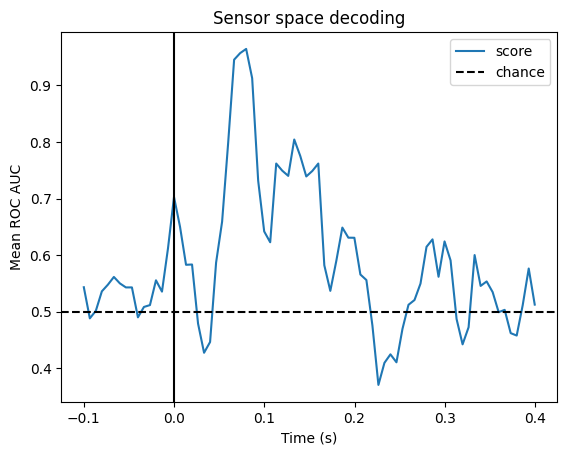

In [15]:
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator

X = epochs_decoding.get_data()
y = epochs_decoding.events[:, 2]


clf = make_pipeline(StandardScaler(),
                    logreg)

time_decod = SlidingEstimator(clf, scoring='roc_auc', n_jobs=1, verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits, for each time point.
mean_scores = np.mean(scores, axis=0)

# Mean score across all time points.
mean_across_all_times = np.mean(scores)
print(f'Mean CV score across all time points: {mean_across_all_times:.3f}')

# Plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(epochs.times, mean_scores, label='score')
ax.axhline(0.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean ROC AUC')
ax.legend()
ax.axvline(0, color='k', linestyle='-')
ax.set_title('Sensor space decoding');

## Decoding source space data

Now, we want to perform decoding of MEG data in the source space. This involes to solve the ill-posed MEG inverse problem. We apply the pre computed inverse operator to single trials and use as inverse method dSPM.

In [16]:
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator

subjects_dir = data_path / "subjects"
fname_cov = data_path / "MEG/sample/sample_audvis-cov.fif"
fname_inv = data_path / "MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif"

epochs_meg = epochs.copy().pick_types(meg=True)

snr = 3.0

noise_cov = mne.read_cov(fname_cov)
inverse_operator = read_inverse_operator(fname_inv)

stcs = apply_inverse_epochs(
    epochs_meg,
    inverse_operator,
    lambda2=1.0 / snr**2,
    verbose=False,
    method="dSPM",
    pick_ori="normal",
)

`stcs` is a list of the reconstructed time series

In [17]:
stcs[0].rh_data.shape

(3766, 76)

In [18]:
# Retrieve source space data into an array
X = np.array([stc.data for stc in stcs])
y = epochs.events[:, 2]


print(X.shape, y.shape)
print(y)

(108, 7498, 76) (108,)
[1 2 1 2 1 2 1 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 2 1 2 2 1 2 1 2 1 2 1 2
 1 1 2 1 2 1 2 1 2 1 2 2 1 2 1 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 1]


Here univariate feature selection is employed for speed purposes to confine the classification to a small number of potentially relevant features. The classifier then is trained to selected features of epochs in source space.

We perform decoding at each time point in source space using a Logistic Regression

In [19]:
from sklearn.feature_selection import SelectKBest, f_classif

# prepare a series of classifier applied at each time sample
clf = make_pipeline(
    StandardScaler(),  # z-score normalization
    SelectKBest(f_classif, k=500),  # select features for speed
    LinearModel(LogisticRegression(C=1, solver="liblinear")),
)
time_decod = SlidingEstimator(clf, scoring="roc_auc")

# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

  0%|          | Fitting SlidingEstimator : 0/76 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/76 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/76 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/76 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/76 [00:00<?,       ?it/s]

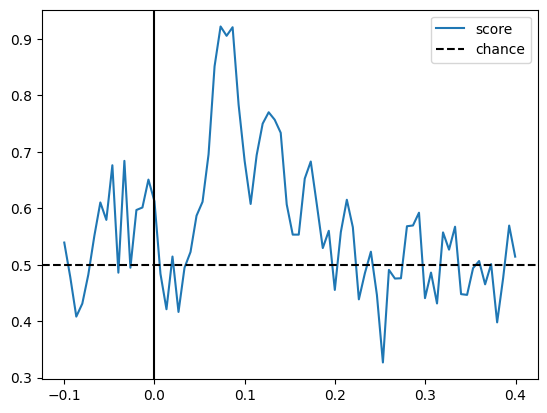

In [20]:
# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(epochs.times, scores.mean(0), label="score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.axvline(0, color="k")
plt.legend();

In [21]:
time_decod

<SlidingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()), ('selectkbest', SelectKBest(k=500)), ('linearmodel', LinearModel(model=LogisticRegression(C=1, solver='liblinear')))]), scoring='roc_auc')>

In [22]:
# The fitting needs not be cross validated because the weights are based on the training sets
time_decod.fit(X, y)

# Retrieve patterns after inversing the z-score normalization step:
patterns = get_coef(time_decod, "patterns_", inverse_transform=True)   

In [23]:
stc = stcs[0]  # for convenience, lookup parameters from first stc
vertices = [stc.lh_vertno, stc.rh_vertno]  # empty array for right hemi
stc_feat = mne.SourceEstimate(
    np.abs(patterns),
    vertices=vertices,
    tmin=stc.tmin,
    tstep=stc.tstep,
    subject="sample",
)

In [24]:
patterns.shape

(7498, 76)

To visualize the patterns on source space you should install pyvistaqt and nibabel packages: \

`pip install pyvistaqt` and  `pip install nibabel`.

In [25]:
brain = stc_feat.plot(
    hemi='both',
    views=["lat"],
    transparent=True,
    initial_time=0.1,
    time_unit="s",
    subjects_dir=subjects_dir,
)

False


<div class="alert alert-success">
    <b>EXERCISES:</b>
     <ul>
      <li>Plot the decoding score over time for the different channel types.</li>
         <li> Do a decoding on source space </li>   
      <li>Do a decoding over time on the SPM `face` dataset to see if you can classify `face` vs. `scrambled face`.</li>
         <li>Do a generalization over time analysis.
</li>
    </ul>
</div>

Hints:

- Access the `face` dataset via:

    ```
    from mne.datasets import spm_face
    data_path = spm_face.data_path()

    raw_fname = os.path.join(data_path, 'MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds')
    raw = mne.io.read_raw_ctf(raw_fname, preload=True)
    ```

- The event IDs are:

    ```
    event_ids = {"faces": 1, "scrambled": 2}
    ```

See this online example for additional hints: https://mne.tools/stable/auto_examples/datasets/spm_faces_dataset.html


<div class="alert alert-block alert-info">
<b>Note:</b> For more details look at the following tutorials: 
    <a href="https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html" target="_blank">Decoding (MVPA)</a> and this book chapter:

Jean-Rémi King, Laura Gwilliams, Chris Holdgraf, Jona Sassenhagen, Alexandre Barachant, Denis Engemann, Eric Larson, Alexandre Gramfort. Encoding and Decoding Neuronal Dynamics: Methodological Framework to Uncover the Algorithms of Cognition. 2018. https://hal.archives-ouvertes.fr/hal-01848442/
</div>
